<a href="https://colab.research.google.com/github/IsmoilDev7/task1/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Izoh: ushbu buyruq malumotva madellar bilan kutubxonalarni ishlatish paketlar bilan ishlash.

In [4]:
!pip install pandas numpy scikit-learn matplotlib seaborn

CSV fayllarni yuklash

In [5]:
import pandas as pd

log = pd.read_csv("journal_logentry.csv")
inspection = pd.read_csv("inspection_inspection.csv")
inspection_type = pd.read_csv("inspection_inspectiontype.csv")
locomotive = pd.read_csv("locomotive_locomotive.csv")
location = pd.read_csv("organization_location.csv")


journal_logentry.csv ni to‘g‘ri tayyorlash

In [6]:
import pandas as pd

log = pd.read_csv("journal_logentry.csv")

# ustunlarni standart nomga moslash
log = log.rename(columns={
    "action": "event_type",
    "created_time": "created_at",
    "author_id": "user_id"
})

log["created_at"] = pd.to_datetime(log["created_at"])


 faqat inspection eventlarni qoldiramiz

In [7]:
log = log[log["event_type"].isin([
    "inspection_opened",
    "inspection_closed"
])]


In [8]:
log["event_type"].value_counts()


,count
event_type,
inspection_opened,12742
inspection_closed,12595


open va close eventlarni ajratish

In [9]:
opened = log[log["event_type"] == "inspection_opened"].copy()
closed = log[log["event_type"] == "inspection_closed"].copy()

opened = opened.sort_values("created_at")
closed = closed.sort_values("created_at")

opened = opened.rename(columns={
    "id": "open_event_id",
    "created_at": "open_time"
})

closed = closed.rename(columns={
    "id": "close_event_id",
    "created_at": "close_time"
})


open  eng yaqin close

In [10]:
cases = []

for _, o in opened.iterrows():
    c = closed[
        (closed["locomotive_id"] == o["locomotive_id"]) &
        (closed["close_time"] > o["open_time"])
    ].head(1)

    if len(c) == 0:
        cases.append({
            "locomotive_id": o["locomotive_id"],
            "organization_id": o["organization_id"],
            "user_id": o["user_id"],
            "open_time": o["open_time"],
            "close_time": None,
            "duration_minutes": None,
            "is_censored": 1
        })
    else:
        duration = (c.iloc[0]["close_time"] - o["open_time"]).total_seconds() / 60
        cases.append({
            "locomotive_id": o["locomotive_id"],
            "organization_id": o["organization_id"],
            "user_id": o["user_id"],
            "open_time": o["open_time"],
            "close_time": c.iloc[0]["close_time"],
            "duration_minutes": duration,
            "is_censored": 0
        })

cases = pd.DataFrame(cases)


In [11]:
cases = cases[
    (cases["duration_minutes"].isna()) |
    (cases["duration_minutes"].between(1, 24*60))
]


inspection_inspection.csv dan inspection_type qo‘shish

In [12]:
cases = cases.merge(
    inspection[["locomotive_id", "inspection_type_id"]],
    on="locomotive_id",
    how="left"
)


inspection_inspectiontype.csv dan nomini olish

In [13]:
inspection_type = pd.read_csv("inspection_inspectiontype.csv")

cases = cases.merge(
    inspection_type[["id", "name"]],
    left_on="inspection_type_id",
    right_on="id",
    how="left",
    suffixes=("", "_type")
)

cases = cases.rename(columns={"name": "inspection_type"})


vaqt xususiyatlari

In [14]:
cases["open_hour"] = cases["open_time"].dt.hour
cases["open_weekday"] = cases["open_time"].dt.weekday


model uchun ma'lumotlar to'plami

In [15]:
model_df = cases[cases["is_censored"] == 0].copy()


kodlash

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
model_df["inspection_type_enc"] = le.fit_transform(
    model_df["inspection_type"].astype(str)
)


X va y

In [17]:
X = model_df[
    ["inspection_type_enc", "open_hour", "open_weekday", "user_id"]
]

y = model_df["duration_minutes"]


poezd / tRAIN_test bo'limi

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Boshlang'ich ko'rsatkich (o'rtacha)

In [19]:
baseline = y_train.median()
baseline_mae = abs(y_test - baseline).mean()
baseline_mae


np.float64(206.20161679853112)

Regressiya modellari (LightGBM)

In [20]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 242722, number of used features: 4
[LightGBM] [Info] Start training from score 266.005185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=300,
              random_state=42)

Baholash

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

mae, rmse

(170.65903688041786, np.float64(254.4429613802986))

Xususiyatning ahamiyati

In [22]:
pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)


,0
open_hour,3375
user_id,3053
open_weekday,2117
inspection_type_enc,437


Yakuniy natija CSV

In [23]:
cases.to_csv("inspection_case_dataset.csv", index=False)


Feature important'ni tushunarli jadvalga chiqarish

In [24]:
pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)


,0
open_hour,3375
user_id,3053
open_weekday,2117
inspection_type_enc,437


Endi uni hisobotga tayyor holatga keltiramiz :

In [25]:
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

feature_importance


,feature,importance
1,open_hour,3375
3,user_id,3053
2,open_weekday,2117
0,inspection_type_enc,437


Agar grafik ham xohlasang:

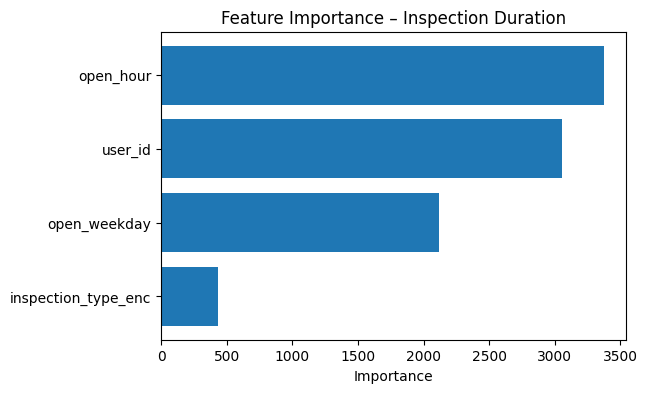

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"]
)
plt.gca().invert_yaxis()
plt.title("Feature Importance – Inspection Duration")
plt.xlabel("Importance")
plt.show()


Baseline vs Modelni baholash (

In [28]:
print("Baseline MAE (median):", round(baseline_mae, 2))
print("LightGBM MAE:", round(mae, 2))
print("LightGBM RMSE:", round(rmse, 2))


Baseline MAE (median): 206.2
LightGBM MAE: 170.66
LightGBM RMSE: 254.44


Prediction usullarini test seti bilan birga saqlash (Excel)

In [29]:
test_results = X_test.copy()

test_results["actual_duration"] = y_test.values
test_results["predicted_duration"] = pred
test_results["error_minutes"] = (
    test_results["predicted_duration"] -
    test_results["actual_duration"]
)

test_results.head()


,inspection_type_enc,open_hour,open_weekday,user_id,actual_duration,predicted_duration,error_minutes
171079,5,6,0,60.0,412.507738,364.501313,-48.006425
110680,6,1,6,12.0,89.257640,221.261834,132.004195
202183,6,21,1,15.0,1.158385,138.045477,136.887093
86974,7,16,2,61.0,513.549668,381.157279,-132.392389
238138,6,22,4,59.0,175.304406,262.758269,87.453863


Excel (CSV) qilib yuklab olish

In [30]:
test_results.to_csv(
    "task1_inspection_duration_predictions.csv",
    index=False
)

feature_importance.to_csv(
    "task1_feature_importance.csv",
    index=False
)

cases.to_csv(
    "task1_case_level_dataset.csv",
    index=False
)

print("✅ Task 1 barcha natijalar CSV ga saqlandi")


✅ Task 1 barcha natijalar CSV ga saqlandi


In [32]:
from google.colab import files
files.download("task1_inspection_duration_predictions.csv")
files.download("task1_feature_importance.csv")
files.download("task1_case_level_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>